In [0]:
from keras.layers import Dense,Reshape,Input,Flatten,Dropout,BatchNormalization,ZeroPadding2D,Activation
from keras.layers.advanced_activations import LeakyReLU
from keras.layers.convolutional import UpSampling2D,Conv2D
from keras.models import Model
from keras.optimizers import Adam
from keras.datasets import mnist
import matplotlib.pyplot as plt
import numpy as np

In [0]:
def build_generator(noise_shape = (100,)):
  inp = Input(noise_shape)
  x = Dense(128*7*7,activation = "relu")(inp)
  x = Reshape((7,7,128))(x)
  x = BatchNormalization(momentum = 0.8)(x)
  x = UpSampling2D()(x)
  x = Conv2D(128,kernel_size = 3,padding = "same")(x)
  x = Activation("relu")(x)
  x = BatchNormalization(momentum=0.8)(x)
  x = UpSampling2D()(x)
  x = Conv2D(64,kernel_size = 3,padding = "same")(x)
  x = Activation("relu")(x)
  x = BatchNormalization(momentum=0.8)(x)
  x = Conv2D(1,kernel_size = 3,padding = "same")(x)
  out = Activation("tanh")(x)
  model = Model(inp, out)
  print("-- Generator -- ")
  model.summary()
  return model

In [0]:
def build_discriminator(img_shape):
  inp = Input(img_shape)
  x = Conv2D(32,kernel_size = 3,strides = 2,padding = "same")(inp)
  x = LeakyReLU(alpha = 0.2)(x)
  x = Dropout(0.25)(x)
  x = Conv2D(64,kernel_size =3,strides = 2,padding = "same")(x)
  x = ZeroPadding2D(padding = ((0,1),(0,1)))(x)
  x = LeakyReLU(alpha = 0.2)(x)
  x = Dropout(0.25)(x)
  x = BatchNormalization(momentum = 0.8)(x)
  x = Conv2D(128, kernel_size=3, strides=2, padding="same")(x)
  x = LeakyReLU(alpha=0.2)(x)
  x = Dropout(0.25)(x)
  x = BatchNormalization(momentum=0.8)(x)
  x = Conv2D(256, kernel_size=3, strides=1, padding="same")(x)
  x = LeakyReLU(alpha=0.2)(x)
  x = Dropout(0.25)(x)
  x = Flatten()(x)
  out = Dense(1, activation='sigmoid')(x)

  model = Model(inp, out)
  print("-- Discriminator -- ")
  model.summary()
  return model

In [0]:
def load_data():
  (x_train,_),(_,_) = mnist.load_data()
  x_train = (x_train.astype(np.float32) - 127.5) / 127.5
  x_train = np.expand_dims(x_train, axis=3)
  return x_train

In [0]:
def build_models():
  gen_optimizer = Adam(lr = 0.0002,beta_1 = 0.5)
  disc_optimizer = Adam(lr = 0.0002,beta_1 = 0.5)
  
  discriminator = build_discriminator(img_shape = (28,28,1))
  discriminator.compile(loss = "binary_crossentropy",optimizer = disc_optimizer,metrics = ["accuracy"])
  
  generator = build_generator()
  generator.compile(loss='binary_crossentropy', optimizer=gen_optimizer)
  
  z = Input((100,))
  img  = generator(z)
  discriminator.trainable = False
  real = discriminator(img)
  combined = Model(z,real)
  combined.compile(loss='binary_crossentropy', optimizer=gen_optimizer)
  return generator, discriminator, combined

In [0]:
def save_imgs(generator, epoch, batch):
    r, c = 5, 5
    noise = np.random.normal(0, 1, (r * c, 100))
    gen_imgs = generator.predict(noise)

    # Rescale images 0 - 1
    gen_imgs = 0.5 * gen_imgs + 0.5

    fig, axs = plt.subplots(r, c)
    cnt = 0
    for i in range(r):
        for j in range(c):
            axs[i, j].imshow(gen_imgs[cnt, :, :, 0], cmap='gray')
            axs[i, j].axis('off')
            cnt += 1
    fig.savefig("images/mnist_%d_%d.png" % (epoch, batch))
    plt.close()


In [0]:
!mkdir images

In [0]:
def train(generator,discriminator,combined,epochs = 2000,batch_size = 128,save_interval =100):
    X_train = load_data()

    num_examples = X_train.shape[0]
    num_batches = int(num_examples / float(batch_size))
    print('Number of examples: ', num_examples)
    print('Number of Batches: ', num_batches)
    print('Number of epochs: ', epochs)
    
    half_batch = int(batch_size/2)
    
    for epoch in range(epochs+1):
      for batch in range(num_batches):
                    # noise images for the batch
            noise = np.random.normal(0, 1, (half_batch, 100))
            fake_images = generator.predict(noise)
            fake_labels = np.zeros((half_batch, 1))

            # real images for batch
            idx = np.random.randint(0, X_train.shape[0], half_batch)
            real_images = X_train[idx]
            real_labels = np.ones((half_batch, 1))

            # Train the discriminator (real classified as ones and generated as zeros)
            d_loss_real = discriminator.train_on_batch(real_images, real_labels)
            d_loss_fake = discriminator.train_on_batch(fake_images, fake_labels)
            d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)

            noise = np.random.normal(0, 1, (batch_size, 100))
            # Train the generator
            g_loss = combined.train_on_batch(noise, np.ones((batch_size, 1)))

            # Plot the progress
            print("Epoch %d Batch %d/%d [D loss: %f, acc.: %.2f%%] [G loss: %f]" %
                  (epoch,batch, num_batches, d_loss[0], 100 * d_loss[1], g_loss))

            if batch % save_interval == 0:
                save_imgs(generator, epoch, batch)


In [0]:
gen,disc,adv = build_models()
train(gen,disc,adv,epochs=20,save_interval=200)

In [0]:
gen.save("generator.h5")
disc.save("discriminator.h5")
adv.save("adversarial.h5")

In [0]:
!mv "/content/images" "/content/drive/My Drive"

In [0]:
z = np.random.normal(0,1,(1,100))

In [0]:
img = gen.predict(z)

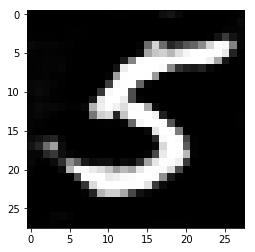

In [49]:
plt.imshow(img.reshape((28,28)),cmap="gray")